<a href="https://colab.research.google.com/github/MickaRiv/ProjetDatascientest-VoiceSeparator/blob/Stan/notebooks/U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs et imports

In [5]:
!pip install nussl

  Using cached nussl-1.1.9-py2.py3-none-any.whl (239 kB)
  Using cached soxbindings-1.2.3-cp37-cp37m-manylinux2010_x86_64.whl (3.3 MB)
  Using cached jams-0.3.4.tar.gz (51 kB)
  Using cached zarr-2.10.3-py3-none-any.whl (146 kB)
  Using cached museval-0.4.0-py2.py3-none-any.whl (21 kB)
  Using cached musdb-0.4.0-py2.py3-none-any.whl (29 kB)
  Using cached termtables-0.2.4-py3-none-any.whl (17 kB)
  Using cached ffmpy-0.3.0.tar.gz (4.8 kB)
  Using cached pytorch_ignite-0.4.7-py3-none-any.whl (240 kB)
  Using cached pyloudnorm-0.1.0-py3-none-any.whl (9.3 kB)
  Using cached ffmpeg_python-0.2.0-py3-none-any.whl (25 kB)
  Using cached gpytorch-1.6.0.tar.gz (310 kB)
  Using cached sox-1.4.1-py2.py3-none-any.whl (39 kB)
  Using cached norbert-0.2.1-py2.py3-none-any.whl (11 kB)
  Using cached jsonschema-4.3.2-py3-none-any.whl (71 kB)
  Using cached mir_eval-0.6.tar.gz (87 kB)
  Using cached stempeg-0.2.3-py3-none-any.whl (963 kB)
  Using cached pyaml-21.10.1-py2.py3-none-any.whl (24 kB)
     |

In [3]:
!pip install git+https://github.com/MickaRiv/ProjetDatascientest-VoiceSeparator

  Cloning https://github.com/MickaRiv/ProjetDatascientest-VoiceSeparator to /tmp/pip-req-build-nj881vn_
  Running command git clone -q https://github.com/MickaRiv/ProjetDatascientest-VoiceSeparator /tmp/pip-req-build-nj881vn_
  Created wheel for voice-separator: filename=voice_separator-0.0.1-py3-none-any.whl size=5583 sha256=dabf73956367cca94e5e46fef7addffb2024685a1b8d1cca57de1e85390330c3
  Stored in directory: /tmp/pip-ephem-wheel-cache-4mftlp6q/wheels/89/ad/91/9cded351057b1a842fbbfa97f091da426d85036b0efd2e0273
Successfully built voice-separator


In [6]:
import os
import nussl
import librosa
from matplotlib import pyplot as plt
import numpy as np

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


# Montage du drive

In [9]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Récupération des données

In [10]:
from voicesep.core import get_musdb_data

path = os.path.join("/content",
                    "drive",
                    "MyDrive",
                    "Projet Datascientest",
                    "musdb18")
musdb = get_musdb_data(gather_accompaniment=True,folder=path)
musdb_train = get_musdb_data(gather_accompaniment=True,folder=path,subfolder="train")
musdb_test = get_musdb_data(gather_accompaniment=True,folder=path,subfolder="test")

Ces variables sont des hooks dataset, et pas directement l'entièreté des données (pour ne pas exploser la RAM). Il est possible d'accéder aux items du dataset par le getitem python classique : `musdb[i]`.

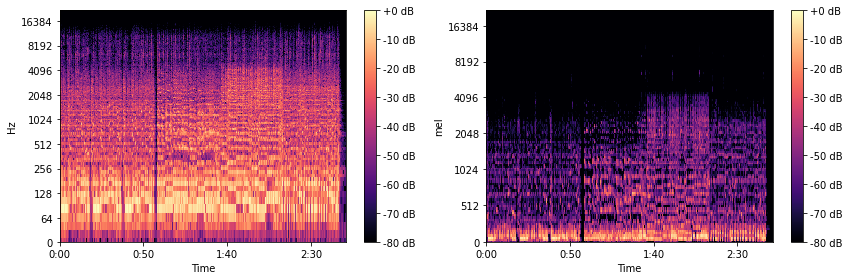

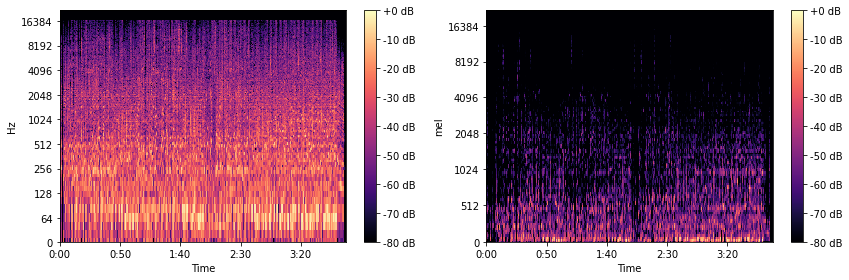

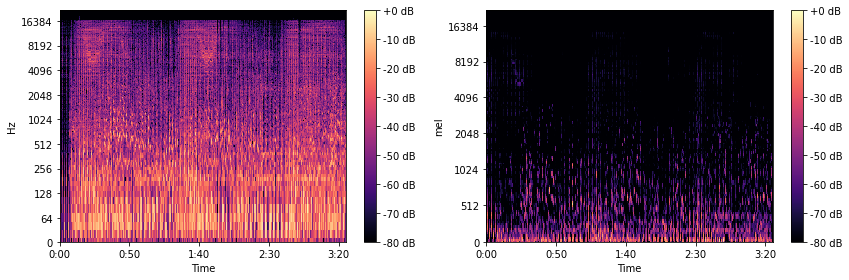

In [ ]:
for i in range(3):
  plt.figure(figsize=(12,4))

  plt.subplot(121)
  nussl.core.utils.visualize_spectrogram(musdb[i]['mix'],y_axis='log')
  plt.colorbar(format='%+2.0f dB')

  plt.subplot(122)
  nussl.core.utils.visualize_spectrogram(musdb[i]['mix'],y_axis="mel")
  plt.colorbar(format='%+2.0f dB')
  plt.ylabel("mel")
  plt.tight_layout()
  plt.show()

# Spectrogrammes et création du dataset

On calcule les spectrogrammes du mix (données d'entrée) et du vocals (ground truth). Les spectres sont concaténés puis découpés pour former une "image" (donnée d'entrée du U-net).
Rem. : faire une fonction, ce serait plus propre

In [11]:
# paramètres de la STFT
freq        =8192     # fréquence de reéchantillonage

window_length =1023    # taille fenêtre FFT
hop_length    =768     # recouvrement FFT

patch_size = 128      # taille du patch temporel pour le CNN (=128 frames temporels)


npistes=30#len(musdb_train)

k=0
time=0
for npiste in range(npistes):

# Spectro voix et mix
  voice=musdb_train[npiste]['sources']["vocals"]
  mix=musdb_train[npiste]['mix']

  time=time+voice.audio_data.shape[1]/voice.sample_rate 

# Resampling à 16 kHz (pour data plus light)
  voice=librosa.resample(voice.audio_data,voice.sample_rate,freq,res_type='kaiser_fast')
  mix  =librosa.resample(mix.audio_data,mix.sample_rate,freq,res_type='kaiser_fast')
# Passage en mono
  voice = librosa.to_mono(voice)
  mix   = librosa.to_mono(mix)
# fft mix et voix (magnitude normalisée et phase)
  stftvoice = librosa.stft(voice,n_fft=window_length,hop_length=hop_length)
  magvoice, phasevoice = librosa.magphase(stftvoice)

  stftmix = librosa.stft(mix,n_fft=window_length,hop_length=hop_length)
  magmix, phasemix = librosa.magphase(stftmix)

  norm = magmix.max()
  magmix /= norm
  magvoice /= norm

# concatenation
  k=k+1
  print("processing",k)
  if (k==1):
    X_mix   =magmix
    X_voice =magvoice
    phase   =phasemix
  else:
    X_mix  =np.append(X_mix,magmix,axis=1)
    X_voice=np.append(X_voice,magvoice,axis=1)
    phase  =np.append(phase,phasemix,axis=1)


# transposition pour mettre le temps en première composante  
X_mix=X_mix.T
X_voice=X_voice.T
phase=phase.T

nfreq=X_mix.shape[1] 

# split en "images" temporelles de taille patch_size (128 dans le papier d'origine)
nimages=X_mix.shape[0]//patch_size   # nombre total d'images
newsize=nimages*patch_size           # nouvelle taille pour un découpage qui tombe juste 

print('Data set: ',k, 'songs')
print('Data set: ',time, 'total time (s)')
print('Data set: ',nimages, 'training images with size',patch_size,'x',nfreq)

X_mix_resized  =X_mix  [:newsize,:]
X_voice_resized=X_voice[:newsize,:]
phase_resized=phase[:newsize,:]

X_mix=np.array(np.split(X_mix_resized, nimages, axis=0))    # découpage 
X_voice=np.array(np.split(X_voice_resized, nimages, axis=0))
phase=np.array(np.split(phase_resized, nimages, axis=0))

X_mix=np.expand_dims(X_mix,axis=3) # rajout d'une dimension (canal) 
X_voice=np.expand_dims(X_voice,axis=3)


processing 1
processing 2
processing 3
processing 4
processing 5
processing 6
processing 7
processing 8
processing 9
processing 10
processing 11
processing 12
processing 13
processing 14
processing 15
processing 16
processing 17
processing 18
processing 19
processing 20
processing 21
processing 22
processing 23
processing 24
processing 25
processing 26
processing 27
processing 28
processing 29
processing 30
Data set:  30 songs
Data set:  7389.820226757368 total time (s)
Data set:  615 training images with size 128 x 512


# Création du U-Net

U-Net tiré de Jansson et al.

Input: "image" de spectrogramme : taille nframes x nfreq
(papier d'origine nframes=128 et nfreq=512)

Output: Mask M (0/1) de même dimension

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, BatchNormalization, Conv2D, Conv2DTranspose , Dropout, Concatenate,  LeakyReLU, ReLU, Activation

# Rem. dimensionnement du papier  nframes=128 nfreq=512


# Création de la structure
nframes=patch_size
inputs=Input(shape =(nframes,nfreq,1) )

conv1 = Conv2D(filters = 16, kernel_size = (5,5) , strides=2, padding='same')(inputs)
conv1 = BatchNormalization()(conv1)
conv1 = LeakyReLU(alpha=0.2)(conv1)

conv2 = Conv2D(filters = 32, kernel_size = (5,5), strides=2, padding='same')(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = LeakyReLU(alpha=0.2)(conv2)

conv3 = Conv2D(filters = 64, kernel_size = (5,5), strides=2, padding='same')(conv2)
conv3 = BatchNormalization()(conv3)
conv3 = LeakyReLU(alpha=0.2)(conv3)

conv4 = Conv2D(filters = 128, kernel_size = (5,5), strides=2, padding='same')(conv3)
conv4 = BatchNormalization()(conv4)
conv4 = LeakyReLU(alpha=0.2)(conv4)

conv5 = Conv2D(filters = 256, kernel_size = (5,5), strides=2, padding='same')(conv4)
conv5 = BatchNormalization()(conv5)
conv5 = LeakyReLU(alpha=0.2)(conv5)

conv6 = Conv2D(filters = 512, kernel_size = (5,5), strides=2, padding='same')(conv5)
conv6 = BatchNormalization()(conv6)
conv6 = LeakyReLU(alpha=0.2)(conv6)

deconv7 = Conv2DTranspose(filters = 256, kernel_size = (5,5), strides=2, padding='same')(conv6)
deconv7 = BatchNormalization()(deconv7)
deconv7 = Dropout(0.5)(deconv7)
deconv7 = ReLU()(deconv7)
deconv7 = Concatenate(axis=3)([deconv7, conv5])

deconv8 = Conv2DTranspose(filters = 128, kernel_size = (5,5), strides=2, padding='same')(deconv7)
deconv8 = BatchNormalization()(deconv8)
deconv8 = Dropout(0.5)(deconv8)
deconv8 = ReLU()(deconv8)
deconv8 = Concatenate(axis=3)([deconv8, conv4])

deconv9 = Conv2DTranspose(filters = 64, kernel_size = (5,5), strides=2, padding='same')(deconv8)
deconv9 = BatchNormalization()(deconv9)
deconv9 = Dropout(0.5)(deconv9)
deconv9 = ReLU()(deconv9)
deconv9= Concatenate(axis=3)([deconv9, conv3])

deconv10 = Conv2DTranspose(filters = 32, kernel_size = (5,5), strides=2, padding='same')(deconv9)
deconv10 = BatchNormalization()(deconv10)
deconv10 = ReLU()(deconv10)
deconv10 = Concatenate(axis=3)([deconv10, conv2])

deconv11 = Conv2DTranspose(filters = 16, kernel_size = (5,5), strides=2, padding='same')(deconv10)
deconv11 = BatchNormalization()(deconv11)
deconv11 = ReLU()(deconv11)
deconv11 = Concatenate(axis=3)([deconv11, conv1])

deconv12 = Conv2DTranspose(filters = 1, kernel_size = (5,5), strides=2, padding='same')(deconv11)
deconv12 = Activation('sigmoid')(deconv12)

outputs = tf.multiply(inputs,deconv12)

unet = Model(inputs=inputs, outputs=outputs)
#unet.summary()


unet.compile(loss='mean_absolute_error',   
              optimizer='adam')            

train_history=unet.fit(X_mix,X_voice,
                       validation_split=0.1,
                       epochs=25,
                       batch_size=8)





#définition de la loss function 
#def myloss(y_true, y_pred):
#    return tf.reduce_mean(squared_difference, axis=-1) 


Epoch 1/25
70/70 [==============================] - 93s 1s/step - loss: 0.0039 - val_loss: 0.0048
Epoch 2/25
70/70 [==============================] - 85s 1s/step - loss: 0.0032 - val_loss: 0.0046
Epoch 3/25
70/70 [==============================] - 84s 1s/step - loss: 0.0029 - val_loss: 0.0050
Epoch 4/25
70/70 [==============================] - 84s 1s/step - loss: 0.0027 - val_loss: 0.0048
Epoch 5/25
70/70 [==============================] - 108s 2s/step - loss: 0.0026 - val_loss: 0.0039
Epoch 6/25
70/70 [==============================] - 102s 1s/step - loss: 0.0025 - val_loss: 0.0038
Epoch 7/25
70/70 [==============================] - 97s 1s/step - loss: 0.0024 - val_loss: 0.0043
Epoch 8/25
70/70 [==============================] - 92s 1s/step - loss: 0.0024 - val_loss: 0.0037
Epoch 9/25
70/70 [==============================] - 85s 1s/step - loss: 0.0023 - val_loss: 0.0035
Epoch 10/25
70/70 [==============================] - 85s 1s/step - loss: 0.0023 - val_loss: 0.0033
Epoch 11/25
70/70

# Evaluations

AudioSignal (unlabeled): 15.859 sec @ path unknown, 8192 Hz, 1 ch.
True mix


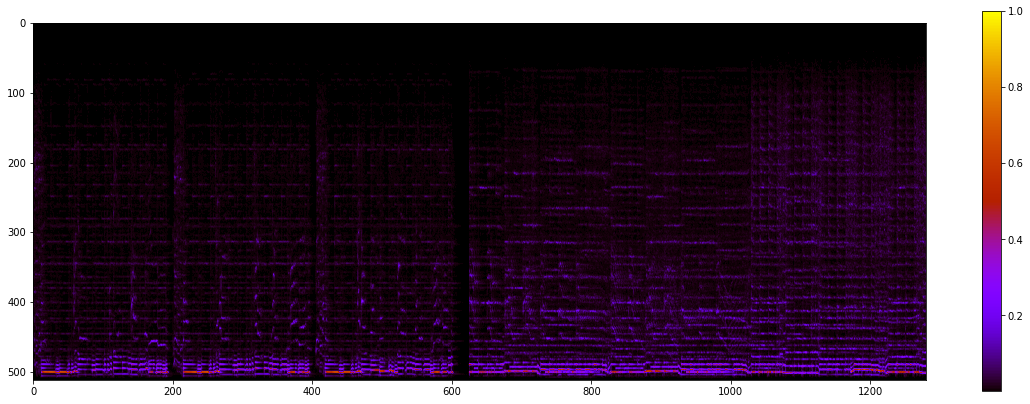

True voice


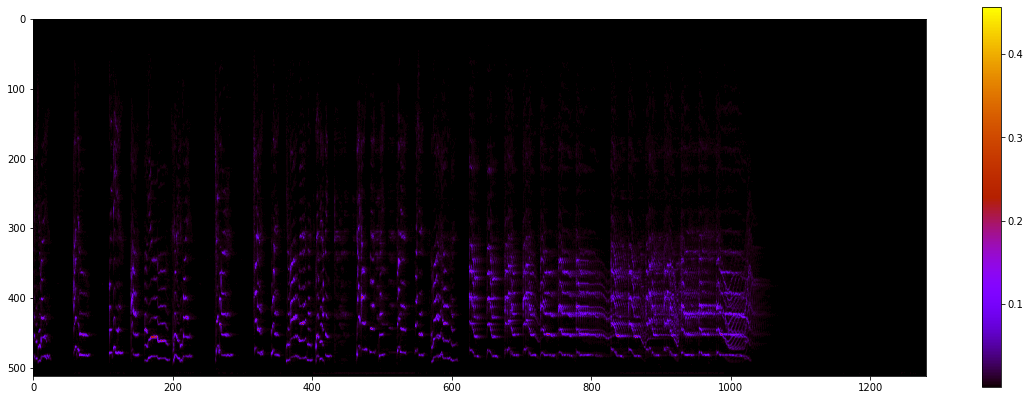

Predicted voice


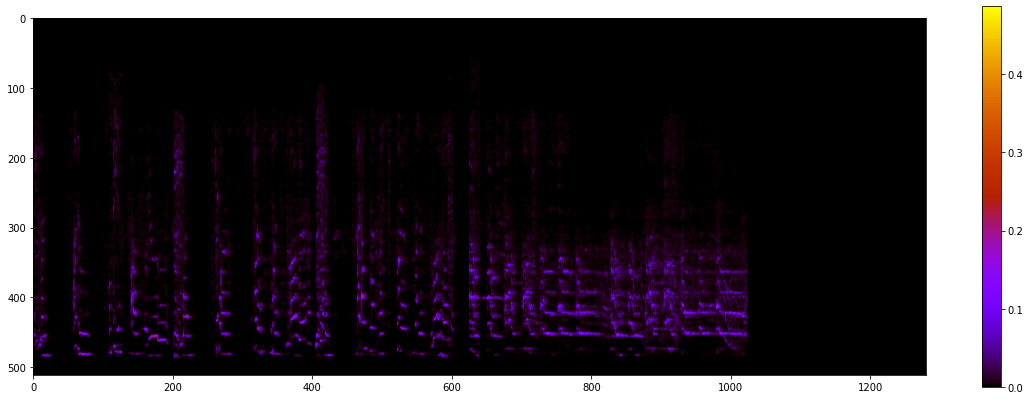

In [18]:
# essai de sortie d'une prédiction à écouter (sur Xmix[0] )
#ytest =unet.predict(X_mix[9,:,:,:].reshape(-1,nframes,nfreq,1))

voicesep=ytest.reshape(nframes,nfreq)*phase[0,:,:]
y = librosa.istft(voicesep.T, window_length,hop_length)

signal = nussl.AudioSignal(audio_data_array=y, sample_rate=freq)
signal.embed_audio()
print(signal)

print("True mix")
plt.figure(figsize=(20,7))
mix_to_plot = np.concatenate([X_mix[i] for i in range(10)])
plt.imshow(mix_to_plot[:,::-1,0].T,cmap="gnuplot")
plt.colorbar()
plt.show()

print("True voice")
plt.figure(figsize=(20,7))
mix_to_plot = np.concatenate([X_voice[i] for i in range(10)])
plt.imshow(mix_to_plot[:,::-1,0].T,cmap="gnuplot")
plt.colorbar()
plt.show()

ytest = unet.predict(X_mix[0:10].reshape(-1,nframes,nfreq,1))
print("Predicted voice")
plt.figure(figsize=(20,7))
mix_to_plot = np.concatenate([ytest[i] for i in range(10)])
plt.imshow(mix_to_plot[:,::-1,0].T,cmap="gnuplot")
plt.colorbar()
plt.show()